## 1. Setup

In [2]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [3]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
%%R

# My commonly used R imports
require('flexplot')
require('tidyverse')
library(ggrepel)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: flexplot
Loading required package: tidyverse
In addition: Warning message:
In library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE,  :
  there is no package called ‘flexplot’


## 2. Load file, clean up and create new variables

In [5]:
df = pd.read_csv('2023_subway_censusvar.csv')

In [8]:
# create new column 'maintenance_time' 
# to calculate the time between 'Out of Service Date' and 'Actual Return to Service Date'

from datetime import datetime
df['Out of Service Date'] = pd.to_datetime(df['Out of Service Date'])
df['Actual Return to Service Date'] = pd.to_datetime(df['Actual Return to Service Date'])

df['maintenance_time'] = df['Actual Return to Service Date'] - df['Out of Service Date'] 

# df['maintenance_time'] into hours
df['maintenance_time'] = df['maintenance_time'].dt.total_seconds() / 3600

# rename 'Outage Code' to 'outage_code'
df.rename(columns={'Outage Code': 'outage_code'}, inplace=True)
df.to_csv('processed_data/2023_subway_censusvar_multire.csv', index=False)

In [20]:
df['maintenance_time'].isna().value_counts()

maintenance_time
False    15164
True      3044
Name: count, dtype: int64

In [18]:
df['maintenance_time'].describe()

count    15164.000000
mean         7.394358
std         55.056658
min          0.000000
25%          1.566667
50%          3.433333
75%          5.000000
max       3211.600000
Name: maintenance_time, dtype: float64

## 3. Load multivariable file and plot charts

In [10]:
%%R -o df
df <- read_csv('processed_data/2023_subway_censusvar_multire.csv')

Rows: 18208 Columns: 51
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (26): Common Name, Equipment Description, Executive Comment, outage_cod...
dbl  (21): GEOID, Outage, Station MRN, Station ID, Complex ID, lat, long, AD...
dttm  (4): Out of Service Date, Estimated Return to Service Date, Actual Ret...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### 1D charts

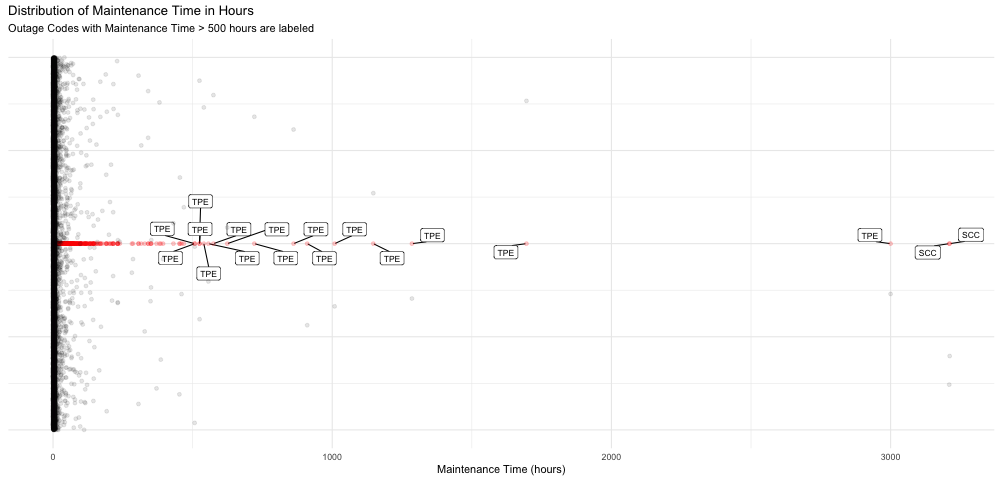

In [91]:
%%R -w 1000

df %>%
    filter(!is.na(maintenance_time)) %>%
    # filter(maintenance_time < 250) %>%
    ggplot() +
    aes(x = maintenance_time, y=1) +
    # for dots with maintenance_time > 1000 add text of their outage codes
    # increase max.overlaps to avoid overlapping text
    geom_label_repel(aes(label = ifelse(maintenance_time > 500, outage_code, '')), size = 3, box.padding = 0.5, max.overlaps=Inf) +
    geom_boxplot(color = 'red', alpha=.2) +
    geom_jitter(alpha = 0.1) +
    theme_minimal() +
    theme(axis.text.y = element_blank(), axis.title.y = element_blank()) +
    labs(title = 'Distribution of Maintenance Time in Hours', subtitle = 'Outage Codes with Maintenance Time > 500 hours are labeled', x = 'Maintenance Time (hours)') 

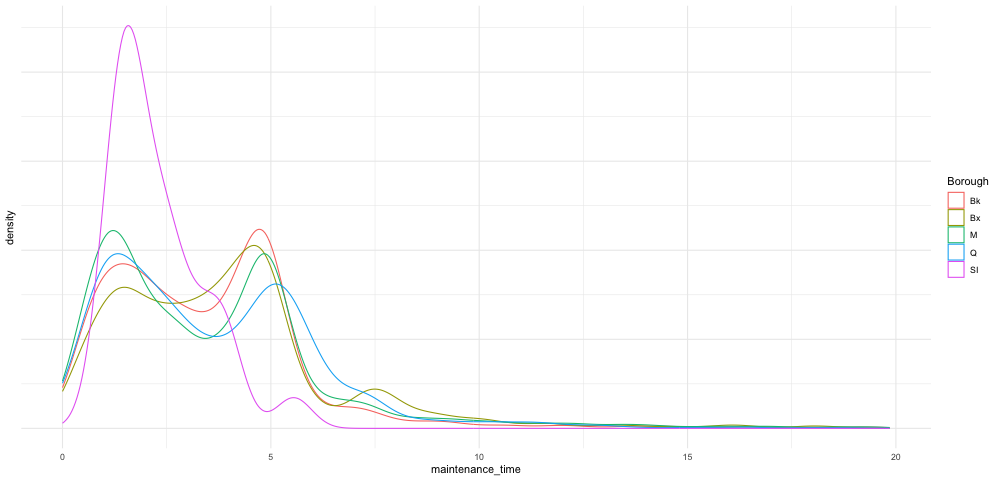

In [49]:
%%R -w 1000

df %>%
    filter(!is.na(maintenance_time)) %>%
    filter(maintenance_time < 20) %>%
    ggplot() +
    aes(x = maintenance_time, color = Borough) +
    geom_density() +
    theme_minimal() +
    # remove y ticks
    theme(axis.text.y=element_blank(), axis.ticks.y=element_blank()) 

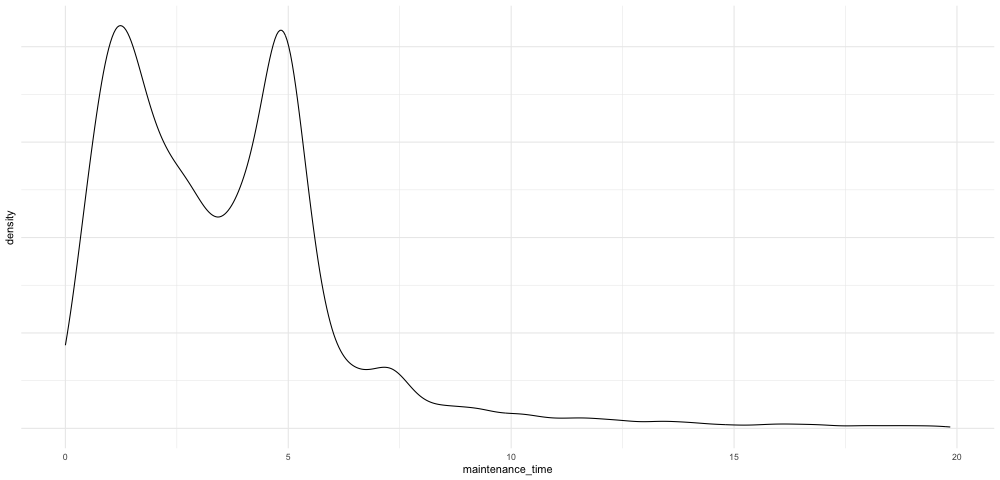

In [52]:
%%R -w 1000

df %>%
    filter(!is.na(maintenance_time)) %>%
    filter(maintenance_time < 20) %>%
    ggplot() +
    aes(x = maintenance_time) +
    geom_density() +
    theme_minimal() +
    # remove y ticks
    theme(axis.text.y=element_blank(), axis.ticks.y=element_blank()) 

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Groups with fewer than two data points have been dropped. 

R[write to console]: 2: Groups with fewer than two data points have been dropped. 

R[write to console]: 3: Groups with fewer than two data points have been dropped. 

R[write to console]: 4: 
R[write to console]: In max(ids, na.rm = TRUE) :
R[write to console]: 
 
R[write to console]:  no non-missing arguments to max; returning -Inf

R[write to console]: 5: 
R[write to console]: In max(ids, na.rm = TRUE) :
R[write to console]: 
 
R[write to console]:  no non-missing arguments to max; returning -Inf

R[write to console]: 6: 
R[write to console]: In max(ids, na.rm = TRUE) :
R[write to console]: 
 
R[write to console]:  no non-missing arguments to max; returning -Inf



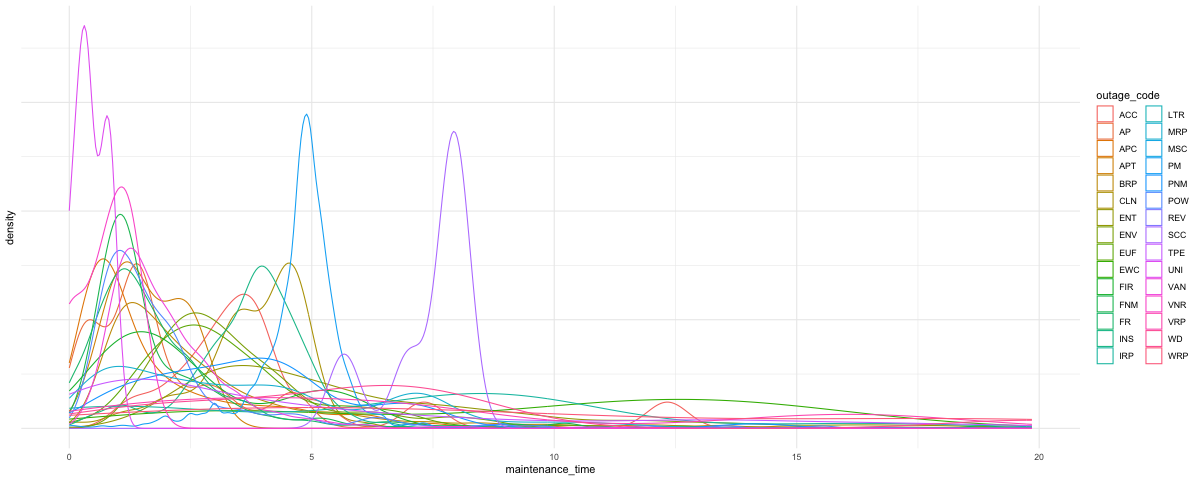

In [129]:
%%R -w 1200

df %>%
    filter(!is.na(maintenance_time)) %>%
    filter(maintenance_time < 20) %>%
    ggplot() +
    aes(x = maintenance_time, color=outage_code) +
    geom_density() +
    theme_minimal() +
    # remove y ticks
    theme(axis.text.y=element_blank(), axis.ticks.y=element_blank()) 

## 4. Multivariable regression 

**Initial thought**
- Y= Time to repair (FOIL)
- X1= Outage code (FOIL data) - `outage_code`
- X2= Ridership in each tract (Census Data) - `sub_pop_estimate`
- X3= Median income (Census Data) - `med_earn_estimate`
- X4= Elevated or subway (merged from subway location dataset to FOIL dataset) `Structure`

In [126]:
%%R
# first attempt
# filter down to outage_code == 'CCR'
df2 <- df %>%
    filter(outage_code == 'TPE') 
model <- lm(maintenance_time ~ sub_pop_estimate + med_earn_estimate + Structure, data = df2)
model_summary <- summary(model)
model_summary


Call:
lm(formula = maintenance_time ~ sub_pop_estimate + med_earn_estimate + 
    Structure, data = df2)

Residuals:
    Min      1Q  Median      3Q     Max 
-161.57  -44.62  -37.05   -5.30 2916.13 



Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        2.479e+02  5.188e+01   4.779 2.23e-06 ***
sub_pop_estimate   1.092e-02  1.211e-02   0.901   0.3679    
med_earn_estimate -6.713e-04  1.712e-04  -3.920 9.89e-05 ***
StructureElevated -6.825e+01  5.740e+01  -1.189   0.2349    
StructureSubway   -9.233e+01  5.139e+01  -1.797   0.0729 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 186.8 on 584 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.04135,	Adjusted R-squared:  0.03479 
F-statistic: 6.298 on 4 and 584 DF,  p-value: 5.762e-05



In [65]:
%%R

# second attempt
# remove ridership/sub_pop_estimate from the model

model <- lm(maintenance_time ~ outage_code + med_earn_estimate + Structure, data = df)
model_summary <- summary(model)
model_summary


Call:
lm(formula = maintenance_time ~ outage_code + med_earn_estimate + 
    Structure, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-654.60   -2.62   -0.75    1.26 2934.08 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        6.650e+01  1.775e+01   3.747  0.00018 ***
outage_codeAP     -1.874e+00  1.498e+01  -0.125  0.90045    
outage_codeAPC     4.382e-01  1.501e+01   0.029  0.97671    
outage_codeAPT    -5.002e-01  2.733e+01  -0.018  0.98540    
outage_codeBRP     6.755e-01  1.485e+01   0.046  0.96371    
outage_codeCCR     2.263e+02  5.342e+01   4.236 2.29e-05 ***
outage_codeCLN     1.993e-01  1.604e+01   0.012  0.99008    
outage_codeENT     3.457e+00  1.495e+01   0.231  0.81709    
outage_codeENV    -2.696e-01  1.513e+01  -0.018  0.98578    
outage_codeEUF    -7.381e-03  1.546e+01   0.000  0.99962    
outage_codeEWC     1.181e+01  2.019e+01   0.585  0.55848    
outage_codeFIR    -6.986e-01  2.963e+01  -0.024  0.98119   

In [66]:
%%R

# third attempt
# adding ambulatory population

model <- lm(maintenance_time ~ outage_code + med_earn_estimate + amb_pop_estimate + Structure, data = df)
model_summary <- summary(model)
model_summary


Call:
lm(formula = maintenance_time ~ outage_code + med_earn_estimate + 
    amb_pop_estimate + Structure, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-654.89   -2.73   -0.73    1.21 2934.98 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        6.803e+01  1.777e+01   3.828  0.00013 ***
outage_codeAP     -1.824e+00  1.498e+01  -0.122  0.90312    
outage_codeAPC     5.254e-01  1.501e+01   0.035  0.97208    
outage_codeAPT    -6.860e-01  2.733e+01  -0.025  0.97997    
outage_codeBRP     8.107e-01  1.485e+01   0.055  0.95645    
outage_codeCCR     2.264e+02  5.342e+01   4.238 2.26e-05 ***
outage_codeCLN     3.841e-01  1.604e+01   0.024  0.98089    
outage_codeENT     3.599e+00  1.495e+01   0.241  0.80972    
outage_codeENV    -2.541e-01  1.513e+01  -0.017  0.98660    
outage_codeEUF     8.632e-02  1.546e+01   0.006  0.99554    
outage_codeEWC     1.178e+01  2.019e+01   0.584  0.55944    
outage_codeFIR    -1.103e+00  2.963e+01 

In [67]:
%%R

# third attempt
# replacing ambulatory population with population estimate

model <- lm(maintenance_time ~ outage_code + med_earn_estimate + population_estimate + Structure, data = df)
model_summary <- summary(model)
model_summary


Call:
lm(formula = maintenance_time ~ outage_code + med_earn_estimate + 
    population_estimate + Structure, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-654.91   -2.71   -0.74    1.20 2934.96 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          6.812e+01  1.777e+01   3.833 0.000127 ***
outage_codeAP       -1.846e+00  1.498e+01  -0.123 0.901926    
outage_codeAPC       5.036e-01  1.501e+01   0.034 0.973244    
outage_codeAPT      -7.037e-01  2.733e+01  -0.026 0.979458    
outage_codeBRP       7.875e-01  1.485e+01   0.053 0.957693    
outage_codeCCR       2.264e+02  5.342e+01   4.238 2.27e-05 ***
outage_codeCLN       3.587e-01  1.604e+01   0.022 0.982153    
outage_codeENT       3.576e+00  1.495e+01   0.239 0.810918    
outage_codeENV      -2.641e-01  1.513e+01  -0.017 0.986076    
outage_codeEUF       6.449e-02  1.546e+01   0.004 0.996671    
outage_codeEWC       1.176e+01  2.019e+01   0.582 0.560277    
outage_codeFI

In [68]:
%%R

# fourth attempt
# adding Borough

model <- lm(maintenance_time ~ outage_code + med_earn_estimate + Borough + Structure, data = df)
model_summary <- summary(model)
model_summary


Call:
lm(formula = maintenance_time ~ outage_code + med_earn_estimate + 
    Borough + Structure, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-654.63   -2.65   -0.71    1.34 2934.25 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        6.584e+01  1.781e+01   3.697 0.000219 ***
outage_codeAP     -2.407e+00  1.499e+01  -0.161 0.872450    
outage_codeAPC    -6.944e-02  1.502e+01  -0.005 0.996311    
outage_codeAPT    -1.281e+00  2.741e+01  -0.047 0.962712    
outage_codeBRP     1.771e-01  1.485e+01   0.012 0.990484    
outage_codeCCR     2.259e+02  5.343e+01   4.228 2.37e-05 ***
outage_codeCLN    -6.267e-01  1.605e+01  -0.039 0.968851    
outage_codeENT     3.038e+00  1.495e+01   0.203 0.838984    
outage_codeENV    -7.531e-01  1.514e+01  -0.050 0.960319    
outage_codeEUF    -3.935e-01  1.546e+01  -0.025 0.979696    
outage_codeEWC     1.129e+01  2.020e+01   0.559 0.576322    
outage_codeFIR    -1.868e+00  2.965e+01  -0.063 0

## 4-5. Interesting findings?

Aishi added that perhaps some maintenance naturally takes more time. So perhaps try looking at the maintenance that occurs often, but are taking exceptionally more time. 

We start with looking at the outage codes with low p-values from the preliminary multivariable regression, which are
- WRP (Warranty Repair by Rehabilitation / Replacement Contractor)
- TPE
- SCC (Capital - Contract Rehab on Station - Machine OK)
- LTR (Long-term repair)
- CCR(Critical Component Replacement)

And we found that, of all outage codes, **TPE is a frequently occurring outage but also takes a lot of time to repair**. 

In [16]:
df[df['outage_code'] == 'TPE']

,GEOID,Out of Service Date,Common Name,Outage,Equipment Description,Executive Comment,outage_code,Status,External Source Note,Reason Shown to Public,...,geometry,population_estimate,sub_pop_estimate,amb_pop_estimate,med_earn_estimate,population_moe,sub_pop_moe,amb_pop_moe,med_earn_moe,maintenance_time
2539,3.604700e+10,2023-02-10 07:30:00+00:00,EL327X,807554.0,ELE: EL327X - 025 - Jay St-MetroTech - Outside...,None,TPE,Closed,None,REPAIR,...,"list(list(c(-73.990447, -73.990663, -73.990746...",1508.0,670.0,1414.0,154167.0,254.0,111.0,197.0,34801.0,127.483333
2553,3.604700e+10,2023-05-18 19:19:00+00:00,EL327X,868342.0,ELE: EL327X - 025 - Jay St-MetroTech - Outside...,None,TPE,Closed,None,REPAIR,...,"list(list(c(-73.990447, -73.990663, -73.990746...",1508.0,670.0,1414.0,154167.0,254.0,111.0,197.0,34801.0,51.433333
2618,3.604700e+10,2023-02-08 08:26:00+00:00,EL327X,806677.0,ELE: EL327X - 025 - Jay St-MetroTech - Outside...,None,TPE,Closed,None,REPAIR,...,"list(list(c(-73.990447, -73.990663, -73.990746...",1508.0,670.0,1414.0,154167.0,254.0,111.0,197.0,34801.0,4.000000
2655,3.604700e+10,2023-05-09 07:13:00+00:00,EL327X,850886.0,ELE: EL327X - 025 - Jay St-MetroTech - Outside...,None,TPE,Closed,None,REPAIR,...,"list(list(c(-73.990447, -73.990663, -73.990746...",1508.0,670.0,1414.0,154167.0,254.0,111.0,197.0,34801.0,98.066667
2659,3.604700e+10,2023-05-17 14:17:00+00:00,EL327X,866086.0,ELE: EL327X - 025 - Jay St-MetroTech - Outside...,None,TPE,Closed,None,REPAIR,...,"list(list(c(-73.990447, -73.990663, -73.990746...",1508.0,670.0,1414.0,154167.0,254.0,111.0,197.0,34801.0,19.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18020,3.608109e+10,2023-07-19 07:47:00+00:00,EL494X,897095.0,ELE: EL494X - 198 - Howard Beach-JFK Airport -...,None,TPE,Closed,None,REPAIR,...,"list(list(c(-73.842429, -73.841174, -73.839279...",9187.0,701.0,8703.0,97830.0,1183.0,308.0,1129.0,25422.0,32.216667
18021,3.608109e+10,2023-02-14 20:00:00+00:00,EL491X,809054.0,ELE: EL491X - 198 - Howard Beach-JFK Airport -...,None,TPE,Closed,None,REPAIR,...,"list(list(c(-73.842429, -73.841174, -73.839279...",9187.0,701.0,8703.0,97830.0,1183.0,308.0,1129.0,25422.0,524.883333
18022,3.608109e+10,2023-02-10 07:39:00+00:00,EL490X,807557.0,ELE: EL490X - 198 - Howard Beach-JFK Airport -...,None,TPE,Closed,None,REPAIR,...,"list(list(c(-73.842429, -73.841174, -73.839279...",9187.0,701.0,8703.0,97830.0,1183.0,308.0,1129.0,25422.0,143.700000
18023,3.608109e+10,2023-01-09 10:10:00+00:00,EL491X,794280.0,ELE: EL491X - 198 - Howard Beach-JFK Airport -...,None,TPE,Closed,None,REPAIR,...,"list(list(c(-73.842429, -73.841174, -73.839279...",9187.0,701.0,8703.0,97830.0,1183.0,308.0,1129.0,25422.0,861.483333


In [11]:
%%R

df2 <- df %>%
    filter(outage_code == 'TPE') 
model <- lm(maintenance_time ~ sub_pop_estimate + med_earn_estimate + Structure, data = df2)
model_summary <- summary(model)
model_summary


Call:
lm(formula = maintenance_time ~ sub_pop_estimate + med_earn_estimate + 
    Structure, data = df2)

Residuals:
    Min      1Q  Median      3Q 

    Max 
-161.57  -44.62  -37.05   -5.30 2916.13 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        2.479e+02  5.188e+01   4.779 2.23e-06 ***
sub_pop_estimate   1.092e-02  1.211e-02   0.901   0.3679    
med_earn_estimate -6.713e-04  1.712e-04  -3.920 9.89e-05 ***
StructureElevated -6.825e+01  5.740e+01  -1.189   0.2349    
StructureSubway   -9.233e+01  5.139e+01  -1.797   0.0729 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 186.8 on 584 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.04135,	Adjusted R-squared:  0.03479 
F-statistic: 6.298 on 4 and 584 DF,  p-value: 5.762e-05



## 5. Plot response variable chart

In [74]:
%%R
# keep only outage_code + sub_pop_estimate + med_earn_estimate + Structure + Borough + population_estimate + maintenance_time in df_model
df_model <- df %>%
    select(outage_code, sub_pop_estimate, med_earn_estimate, Structure, Borough, population_estimate, maintenance_time)

# pivot df_model from wide to long using pivot_longer on all columns except the index 
# and the column we want to predict (maintenance_time)
df_long <- df_model %>%
    pivot_longer(cols = -c(outage_code, Structure, Borough, maintenance_time), names_to = "variable", values_to = "value")

df_long


# A tibble: 54,624 × 6
   outage_code Structure Borough maintenance_time variable            value
   <chr>       <chr>     <chr>              <dbl> <chr>               <dbl>
 1 PM          Subway    Bx                  4.75 sub_pop_estimate     1004
 2 PM          Subway    Bx                  4.75 med_earn_estimate   21962
 3 PM          Subway    Bx                  4.75 population_estimate  5681
 4 BRP         Subway    Bx                  7.83 sub_pop_estimate     1004
 5 BRP         Subway    Bx                  7.83 med_earn_estimate   21962
 6 BRP         Subway    Bx                  7.83 population_estimate  5681
 7 INS         Subway    Bx                  3.55 sub_pop_estimate     1004
 8 INS         Subway    Bx                  3.55 med_earn_estimate   21962
 9 INS         Subway    Bx                  3.55 population_estimate  5681
10 ENT         Subway    Bx                  3.78 sub_pop_estimate     1004
# ℹ 54,614 more rows
# ℹ Use `print(n = ...)` to see more rows


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 9524 rows containing missing values or values outside the scale range
(`geom_point()`). 



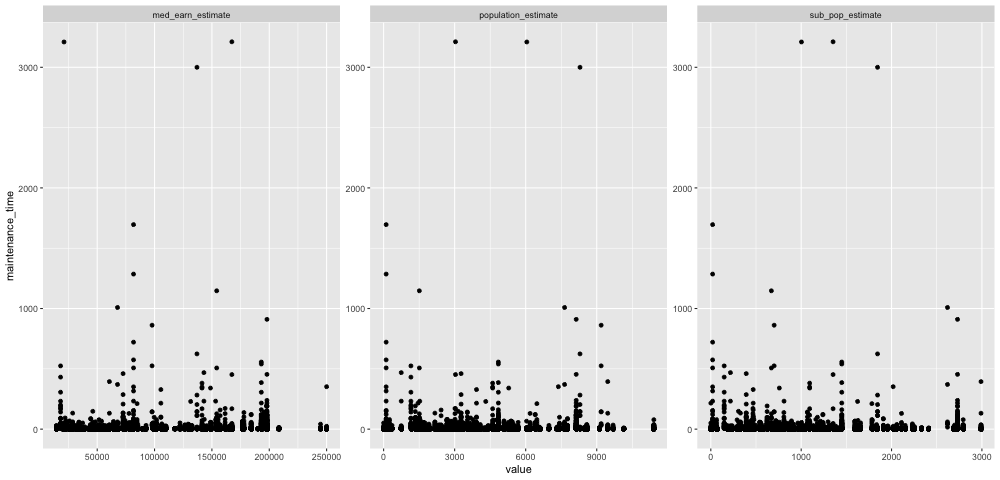

In [78]:
%%R -w 1000

df_long %>%
        ggplot() +
        aes(x=value, y=maintenance_time) +
        geom_point() + 
        # geom_smooth(method = "lm") +
        facet_wrap(~variable, scales = "free")

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 16 rows containing missing values or values outside the scale range
(`geom_point()`). 



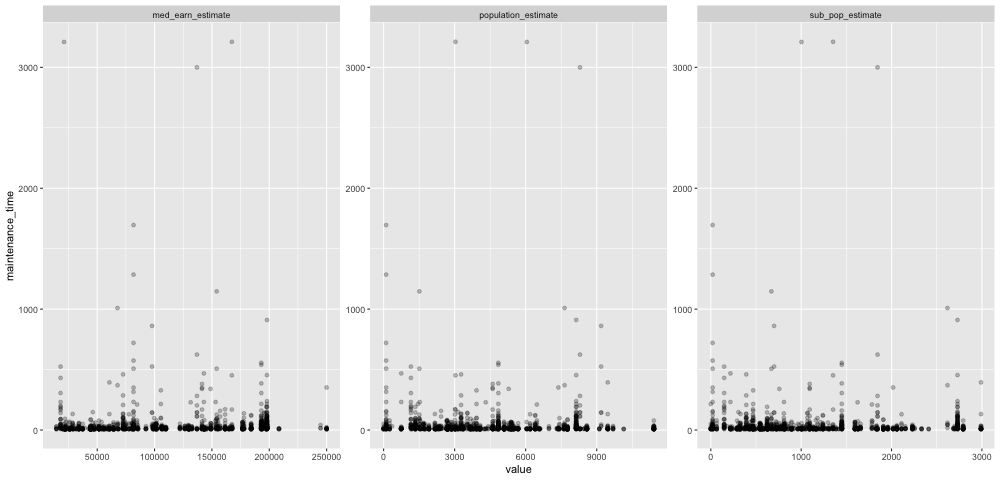

In [83]:
%%R -w 1000

# look at the outliers 
# maintenance_time > 7.3 (mean)
df_long %>%
        filter(maintenance_time > 7.3) %>%
        ggplot() +
        aes(x=value, y=maintenance_time) +
        geom_point(alpha=.25) + 
        # geom_smooth(method = "lm") +
        facet_wrap(~variable, scales = "free")
